In [1]:
import os
import pandas as pd
import numpy as np
import joblib
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_recall_curve, auc, roc_curve

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10,6)
os.environ["LOKY_MAX_CPU_COUNT"] = "4"

In [2]:
# ============================
# 0) Cargar modelos y preprocesadores
# ============================
models_path = r"C:/PROY_FINAL_ML/models/"
best_ridge = joblib.load(os.path.join(models_path, "best_ridge.pkl"))
best_hgb   = joblib.load(os.path.join(models_path, "best_hgb.pkl"))
best_hgb_clf = joblib.load(os.path.join(models_path, "best_hgb_clf.pkl"))
preproc_reg = joblib.load(os.path.join(models_path, "preproc_reg.pkl"))
preproc_clf = joblib.load(os.path.join(models_path, "preproc_clf.pkl"))

# ============================
# 1) Cargar datasets y features
# ============================
df = pd.read_parquet("C:/PROY_FINAL_ML/data/processed/cba_clean.parquet")

X_train = joblib.load("C:/PROY_FINAL_ML/data/processed/X_train.pkl")
X_valid = joblib.load("C:/PROY_FINAL_ML/data/processed/X_valid.pkl")
X_test  = joblib.load("C:/PROY_FINAL_ML/data/processed/X_test.pkl")

y_train = joblib.load("C:/PROY_FINAL_ML/data/processed/y_train.pkl")
y_valid = joblib.load("C:/PROY_FINAL_ML/data/processed/y_valid.pkl")
y_test  = joblib.load("C:/PROY_FINAL_ML/data/processed/y_test.pkl")

y_train_cls = joblib.load("C:/PROY_FINAL_ML/data/processed/y_train_cls.pkl")
y_valid_cls = joblib.load("C:/PROY_FINAL_ML/data/processed/y_valid_cls.pkl")
y_test_cls  = joblib.load("C:/PROY_FINAL_ML/data/processed/y_test_cls.pkl")

num_feats = joblib.load("C:/PROY_FINAL_ML/data/processed/num_feats.pkl")
cat_feats = joblib.load("C:/PROY_FINAL_ML/data/processed/cat_feats.pkl")

print("✅ Datasets y listas de features cargados correctamente.")

✅ Datasets y listas de features cargados correctamente.


In [3]:
# ============================
# 2) Funciones métricas
# ============================
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

In [4]:
# ============================
# 3) Predicciones
# ============================
# Regresión
y_pred_ridge = best_ridge.predict(X_test)
y_pred_hgb   = best_hgb.predict(X_test)

# Clasificación
y_pred_clf   = best_hgb_clf.predict(X_test)
y_proba_clf  = best_hgb_clf.predict_proba(X_test)[:,1]

In [5]:
# ============================
# 4) Métricas
# ============================
metrics_reg = pd.DataFrame({
    "Model": ["Ridge", "HGBReg"],
    "RMSE": [rmse(y_test, y_pred_ridge), rmse(y_test, y_pred_hgb)],
    "MAE":  [mae(y_test, y_pred_ridge), mae(y_test, y_pred_hgb)],
    "R2":   [r2_score(y_test, y_pred_ridge), r2_score(y_test, y_pred_hgb)]
})

metrics_clf = pd.DataFrame({
    "Model": ["HGBCls"],
    "Accuracy": [accuracy_score(y_test_cls, y_pred_clf)],
    "F1-macro": [f1_score(y_test_cls, y_pred_clf, average="macro")],
    "ROC-AUC": [roc_auc_score(y_test_cls, y_proba_clf)]
})

print("=== Métricas Regresión ===")
print(metrics_reg)
print("\n=== Métricas Clasificación ===")
print(metrics_clf)

# Crear carpeta para resultados si no existe
results_dir = r"C:/PROY_FINAL_ML/results"
os.makedirs(results_dir, exist_ok=True)

# Guardar resultados en CSV
metrics_reg.to_csv(os.path.join(results_dir, "metrics_reg.csv"), index=False)
metrics_clf.to_csv(os.path.join(results_dir, "metrics_clf.csv"), index=False)

=== Métricas Regresión ===
    Model      RMSE       MAE        R2
0   Ridge  0.334153  0.112543  0.977612
1  HGBReg  0.334533  0.112330  0.977561

=== Métricas Clasificación ===
    Model  Accuracy  F1-macro   ROC-AUC
0  HGBCls  0.886993  0.588921  0.820709


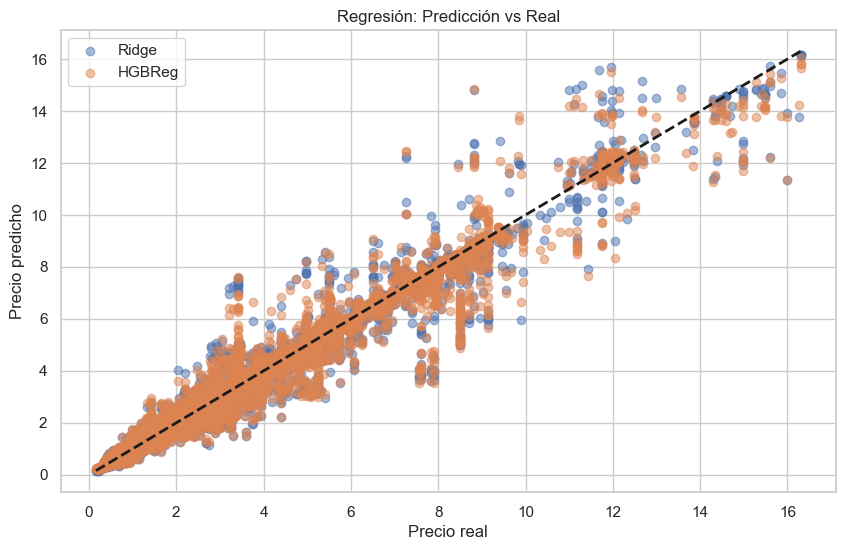

In [6]:
# ============================
# 5) Gráficas – Regresión
# ============================
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_ridge, alpha=0.5, label="Ridge")
plt.scatter(y_test, y_pred_hgb, alpha=0.5, label="HGBReg")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel("Precio real")
plt.ylabel("Precio predicho")
plt.title("Regresión: Predicción vs Real")
plt.legend()
plt.show()

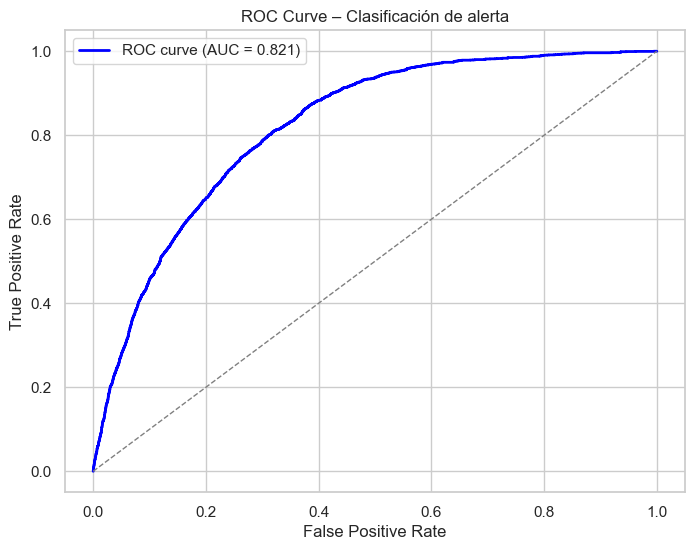

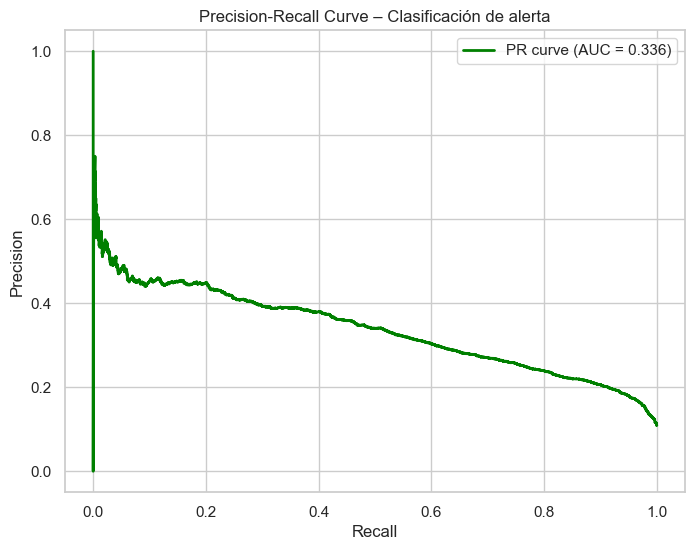

In [7]:
# ============================
# 6) Gráficas – Clasificación ROC y PR
# ============================
fpr, tpr, _ = roc_curve(y_test_cls, y_proba_clf)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – Clasificación de alerta')
plt.legend()
plt.show()

precision, recall, _ = precision_recall_curve(y_test_cls, y_proba_clf)
pr_auc = auc(recall, precision)

plt.figure(figsize=(8,6))
plt.plot(recall, precision, color='green', lw=2, label=f'PR curve (AUC = {pr_auc:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve – Clasificación de alerta')
plt.legend()
plt.show()

 99%|===================| 25187/25432 [01:24<00:00]        

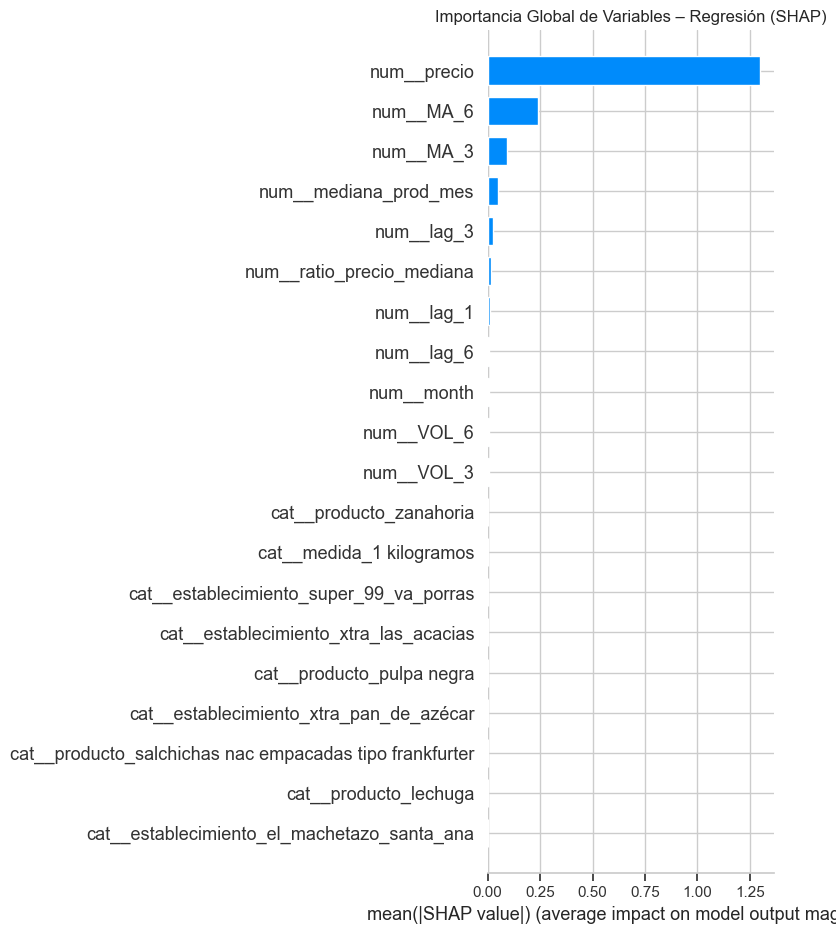

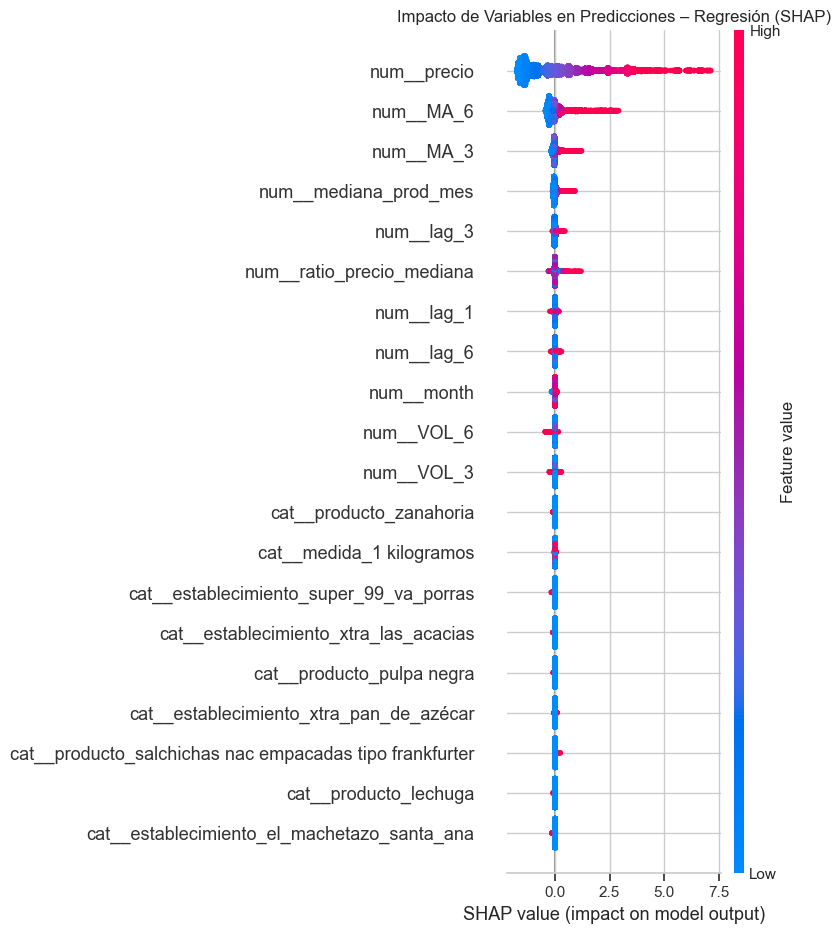

 28%|======              | 7061/25432 [00:48<02:04]       

In [ ]:
# ============================
# 7) SHAP – Explicabilidad
# ============================
# Para Regresión (best_hgb)
X_test_trans = preproc_reg.transform(X_test)
explainer_hgb = shap.Explainer(best_hgb["model"], X_test_trans)
shap_values_hgb = explainer_hgb(X_test_trans, check_additivity=False)#

plt.title("Importancia Global de Variables – Regresión (SHAP)")
shap.summary_plot(
    shap_values_hgb,
    X_test_trans,
    feature_names=preproc_reg.get_feature_names_out(),
    plot_type="bar",
    show=True
)

plt.title("Impacto de Variables en Predicciones – Regresión (SHAP)")
shap.summary_plot(
    shap_values_hgb,
    X_test_trans,
    feature_names=preproc_reg.get_feature_names_out(),
    show=True
)

# Para Clasificación (best_hgb_clf)
X_test_trans_cls = preproc_clf.transform(X_test)
explainer_hgb_cls = shap.Explainer(best_hgb_clf["model"], X_test_trans_cls)
shap_values_hgb_cls = explainer_hgb_cls(X_test_trans_cls, check_additivity=False)

plt.title("Importancia Global de Variables – Clasificación (SHAP)")
shap.summary_plot(
    shap_values_hgb_cls,
    X_test_trans_cls,
    feature_names=preproc_clf.get_feature_names_out(),
    plot_type="bar",
    show=True
)

plt.title("Impacto de Variables en Predicciones – Clasificación (SHAP)")
shap.summary_plot(
    shap_values_hgb_cls,
    X_test_trans_cls,
    feature_names=preproc_clf.get_feature_names_out(),
    show=True
)

In [ ]:
# ============================
# 8) Análisis de error por segmento
# ============================

# Unimos predicciones con metadata
df_test_eval = df.loc[X_test.index].copy()  # Aseguramos que coincidan los índices

df_test_eval["y_real"] = y_test.values
df_test_eval["y_pred"] = y_pred_hgb  # Usamos modelo HGB
df_test_eval["error"] = df_test_eval["y_real"] - df_test_eval["y_pred"]
df_test_eval["abs_error"] = df_test_eval["error"].abs()
df_test_eval["squared_error"] = df_test_eval["error"] ** 2

# Segmentos a evaluar (ajustados a columnas existentes)
segmentos = ["producto", "establecimiento"]

for seg in segmentos:
    print(f"\n Análisis de error por: {seg}")
    seg_stats = df_test_eval.groupby(seg).agg(
        n_obs=("error", "count"),
        RMSE=("squared_error", lambda x: np.sqrt(np.mean(x))),
        MAE=("abs_error", "mean"),
        R2=("y_real", lambda y: r2_score(y, df_test_eval.loc[y.index, "y_pred"])),
        y_real_avg=("y_real", "mean"),
        y_pred_avg=("y_pred", "mean")
    ).sort_values("RMSE", ascending=False)

    # Métrica RMSE normalizada para comparar segmentos con distinto rango
    seg_stats["RMSE_normalized"] = seg_stats["RMSE"] / seg_stats["y_real_avg"]

    print(seg_stats.head(10))  # Top 10 segmentos con más error

    # Guardar resultados
    seg_stats.to_csv(os.path.join(results_dir, f"segment_error_{seg}.csv"))

    # Gráfico opcional
    seg_stats.head(10).plot(kind="barh", y="RMSE", figsize=(10, 5), title=f"Top 10 {seg} con mayor RMSE")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()